In [64]:
import random
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline


# Input

In [65]:
words = open('names.txt', 'r').read().splitlines()
print(f'{len(words)}')
print(max(len(w) for w in words))
words[:8]

32033
15


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

lookup tables

In [76]:
# build the vocab of chars and lookup tables
# Q: what will be the vocab for word level language model?

chars = list('abcdefghijklmnopqrstuvwxyz')
stoi_lookup = {c: i+1 for i, c in enumerate(chars)}
stoi_lookup['.'] = 0
itos_lookups = {i: char for char, i in stoi_lookup.items()}
vocab_size = len(itos_lookups)
print(itos_lookups)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


### Dataset creation

Embeddings lookup table

in [Bengio et al](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), 17k words were embeeded into 30 dims

we have to embed 27 chars into small dims, lets start with 2 dims embedding for now and then increase the dims to say 10 or 12

Build the Dataset

-  both BOS and EOS are represented using '.'

- context - characters to be considered for the next prediction
    - what would be context for the first letter? just '.', the number of '.' will depend on the length of the context


- make sure to represent the EOS as well

In [77]:
block_size = 3 # context length

def build_dataset(words):
    # input and output
    X, Y = [], []
    for word in words:
        # print('word: ', word)
        context = [0] * block_size
        seq = word + '.'    # don't forget to add the . add the end

        for char in seq:
            X.append(context)
            # index of the character to be predicted
            y_idx = stoi_lookup[char]
            Y.append(y_idx)
            # print(''.join(itos_lookups[c] for c in context), '--->', itos_lookups[y_i])
            # update the context for the next sequence
            context = context[1:] + [y_idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print("shapes: ", X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)

train_window_end = int(0.8*len(words))
val_window_end = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:train_window_end])  # used for optimizing the params of the model
X_val, Y_val = build_dataset(words[train_window_end:val_window_end])    #used for training the hyperparameters(hidden layer size, embedding size etc)
X_test, Y_test = build_dataset(words[val_window_end:])  # evaluating the performance of the model

shapes:  torch.Size([182441, 3]) torch.Size([182441])
shapes:  torch.Size([22902, 3]) torch.Size([22902])
shapes:  torch.Size([22803, 3]) torch.Size([22803])


### Build the Network

To get a better understanding how to initialise a network, check out [NN Intialization](https://github.com/priyamore/language-modeling/blob/main/how_to_intialize_nn.ipynb)) 

In [81]:
dim_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, dim_embd),             generator=g)

W1 = torch.randn((dim_embd* block_size, n_hidden),  generator=g) * (5/3)/(dim_embd* block_size) ** 0.5
# b1 = torch.randn(n_hidden,                          generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01 
b2 = torch.randn(vocab_size,                        generator=g) * 0

# -------------- BATCH NORMALIZATION PRAMETERS --------------
# "scale and shift" batch normalization params
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))

# track running mean and stddev
running_bn_mean = torch.zeros((1, n_hidden)) # intialized for a gaussian dist => mean to 0
running_bn_std = torch.ones((1, n_hidden))   # intialized for a gaussian dist => stddev to 1
# ------------------------------------------------------------

params = [C, W1, W2, b2, bn_gain, bn_bias]
print(sum(p.nelement() for p in params))

# set the p.grad requires to true first so that we are able to get the grad for the params
for p in params:
    p.requires_grad = True

12097


### Train the Network

In [82]:
max_steps = 200000
batch_size = 32
losses_at_idx = []

for step in range(max_steps):
    # -------------- MINIBATCH construction --------------
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]
    
    # -------------------- FORWARD PASS -------------------
    # embed the chars into vectors
    emb = C[Xb] # for each entry in the minibatch(32) get a vector(10 dimensions) for each of the three chars of the block/sequence

    # vectors concatenation to make them 2D,
    emb_cat = emb.view(emb.shape[0], -1) # -1 infers the second dimension, should be 30(3*10)

    # ------ linear layer ------
    h_preact = emb_cat @ W1 # hidden layer pre-activation

    # ------------ BATCH NORMALIZATION LAYER ------------
    bn_mean_ix = h_preact.mean(0, keepdim=True)
    bn_std_ix = h_preact.std(0, keepdim=True)
    
    # add batch normalization to normalize the h_preact during training
    # add "scale and shift" for the optimisation 
    h_preact = bn_gain * (h_preact - bn_mean_ix) / bn_std_ix + bn_bias

    # track running mean and stddv
    with torch.no_grad():
        running_bn_mean = 0.999 * running_bn_mean + 0.001 * bn_mean_ix
        running_bn_std = 0.999 * running_bn_std + 0.001 * bn_std_ix

    # ------ NON LINEAR LAYER ------
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, Yb)  # only select the indices in the current mini batch
    # print(f'{loss=}')
    
    # ------ BACKWARD PASS ------
    # set the gradients to 0 - IMP
    for p in params:
        p.grad = None
    
    # calculate the gradients of the loss w.r.t params
    loss.backward()

    l_rate = 0.1 if step < 100000 else 0.01 # learning rate 
    
    # update the params
    for p in params:
        p.data += -l_rate * p.grad

    # track stats
    if step % 10000 == 0: # print periodically
        print(f'{step:7d}/{max_steps:7d}:{loss.item():.4f}')
    
    losses_at_idx.append(loss.log10().item())

# print(f'{loss=}')

      0/ 200000:3.2931
  10000/ 200000:2.1862
  20000/ 200000:2.2031
  30000/ 200000:1.6254
  40000/ 200000:2.2900
  50000/ 200000:1.9870
  60000/ 200000:2.4010
  70000/ 200000:2.2787
  80000/ 200000:1.7903
  90000/ 200000:2.2883
 100000/ 200000:1.9540
 110000/ 200000:1.8947
 120000/ 200000:2.1889
 130000/ 200000:2.0040
 140000/ 200000:2.0210
 150000/ 200000:1.8235
 160000/ 200000:2.5963
 170000/ 200000:2.2080
 180000/ 200000:2.4560
 190000/ 200000:1.9921


Plot losses per step

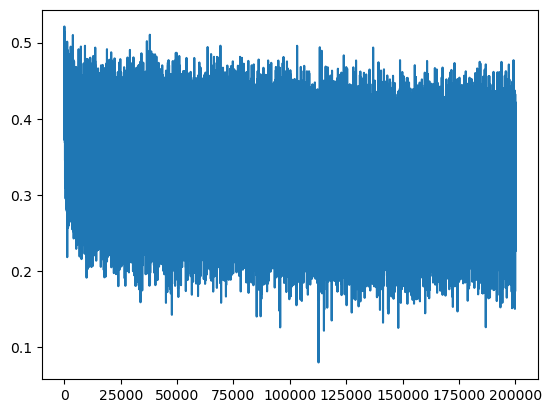

In [61]:
plt.plot(losses_at_idx)

Calculate the training and validation losses

In [83]:
# disable gradient tracking with decorator - 
# this decorator sets the tensors in the function that follows to requires_grad = False
@torch.no_grad() 
def split_losses(split_name):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split_name]

    emb = C[x] # (N, block_size, dim_emb)
    emb_cat = emb.view(emb.shape[0], -1) # concat into (N, block_size * dim_emb)
    h_preact = emb_cat @ W1 # hidden layer pre-activation
    h_preact = bn_gain * (h_preact - running_bn_mean) /running_bn_std + bn_bias
    h = torch.tanh(h_preact) # (N, n_hidden)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split_name, loss.item())

split_losses('train')
split_losses('val')

train 2.0654520988464355
val 2.117046356201172


Sampling from the model

In [80]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        # forward pass 
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim=1)
        ix = torch.multinomial(prob, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos_lookups[i] for i in out))

carman.
amori.
vih.
jarzi.
taty.
salan.
kenletten.
amerynci.
aqui.
ner.
kiah.
maiir.
kaleigh.
ham.
join.
quinn.
shour.
alianni.
wavero.
dearynix.


### Refactor the code to make it modular

In [84]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        # add gain here or handle it while building the network
        self.weight = torch.randn((fan_in, fan_out), generator=g) /fan_in ** 0.5 # fan_in ** 0.5 kaiming init for good initalization
        self.bias = torch.zeros(fan_out) if bias else None
    
    # self function
    def __call__(self, x):
        self.out = x @ self.weight # y = w * x + b
        if self.bias is not None:
            self.out += self.bias

        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

In [85]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # batch norm params
        self.gamma = torch.ones(dim) # scale factor
        self.beta = torch.zeros(dim) # shift
        # buffers for tracking running mean and var
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # forward pass
        if self.training:
            # reset for every mini batch
            x_mean = x.mean(0, keepdim=True)
            x_var = x.var(0, keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var


        x_hat = (x-x_mean)/torch.sqrt(x_var+self.eps) # kaiming init
        self.out = self.gamma * x_hat + self.beta

        # update the running buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


In [86]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

Build the Network

In [9]:
dim_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, dim_embd), generator=g)
layers = [
    Linear(dim_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(             n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1     # with Batch Norm
    # layers[-1].weight *= 0.1    # without batch norm
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

params = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in params))

for p in params:
    p.requires_grad = True


47551


Training

In [10]:
max_steps = 200000
batch_size = 32
losses_at_idx = []
up_d_ratio =[]

for step in range(max_steps):
    # -------------- MINIBATCH construction --------------
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]
    # -----------------------------------------------------

    # -------------------- FORWARD PASS -------------------
    emb = C[Xb] # embed the chars into vectors

    x = emb.view(emb.shape[0], -1) # vectors concatenation to make them 2D
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # ------ BACKWARD PASS ------
    for layer in layers:
        layer.out.retain_grad() # retain the gradients of the output
    # set the gradients to 0 - IMP
    for p in params:
        p.grad = None
    loss.backward() # calculate the gradients of the loss w.r.t params
    # -----------------------------
    l_rate = 0.1 if step < 100000 else 0.01 # learning rate 
    
    # update the params
    for p in params:
        p.data += -l_rate * p.grad

    # track stats
    if step % 10000 == 0: # print periodically
        print(f'{step:7d}/{max_steps:7d}:{loss.item():.4f}')
    
    losses_at_idx.append(loss.log10().item())
    with torch.no_grad():
        up_d_ratio.append([(l_rate*p.grad.std()/p.data.std()).log10().item() for p in params])
    if step >= 1000:
        break

# print(f'{loss=}')

      0/ 200000:3.2870


Visualize Statistics - without adding Batch Normalization Layers

Visualize Activations 

- Try to visualise all types of layers, in this case tanh and linear
- How does the std distribution change for different values of gain?
- When does the saturation stablilise?
    - especially for tanh, notice saturation because the values in the saturation are at the risk of not recieving any gradients in the future due to the flat area, we dont want a high saturated graph
- How is the distribution changing for each layer, if it does?

layer 1 (      Tanh): mean -0.06, std 0.76, saturated: 21.53%
layer 3 (      Tanh): mean +0.01, std 0.72, saturated: 11.72%
layer 5 (      Tanh): mean -0.02, std 0.73, saturated: 13.75%
layer 7 (      Tanh): mean -0.02, std 0.73, saturated: 14.25%
layer 9 (      Tanh): mean -0.01, std 0.70, saturated: 10.31%


Text(0.5, 1.0, 'tanh activation distribution')

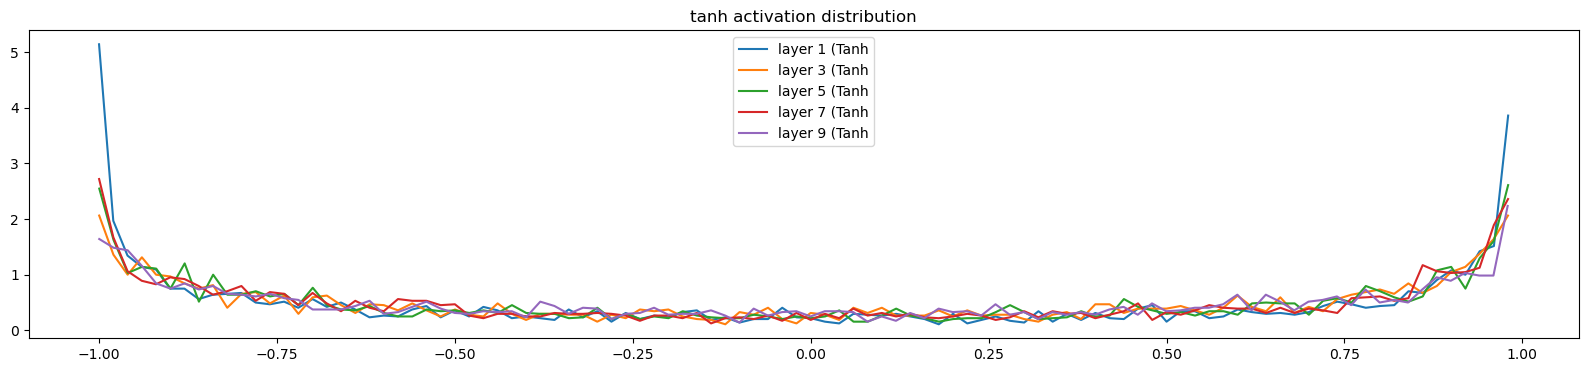

In [165]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # except the softmax layer
    if isinstance(layer, Tanh):
        out = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, out.mean(), out.std(), (out.abs() > 0.97).float().mean() * 100))
        h_y, h_x = torch.histogram(out, density=True)
        plt.plot(h_x[:-1].detach(), h_y.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    
plt.legend(legends);
plt.title('tanh activation distribution')

Visualize tanh Gradients

For all the layers, for different gain
- are the gradients shrinking or exploding? 
- are the gradients stabilising?

layer 1 (      Tanh): mean -0.000048, std 3.441710e-03
layer 3 (      Tanh): mean -0.000058, std 3.294970e-03
layer 5 (      Tanh): mean +0.000016, std 3.042348e-03
layer 7 (      Tanh): mean -0.000035, std 2.901084e-03
layer 9 (      Tanh): mean +0.000016, std 2.376518e-03


Text(0.5, 1.0, 'tanh gradient distribution')

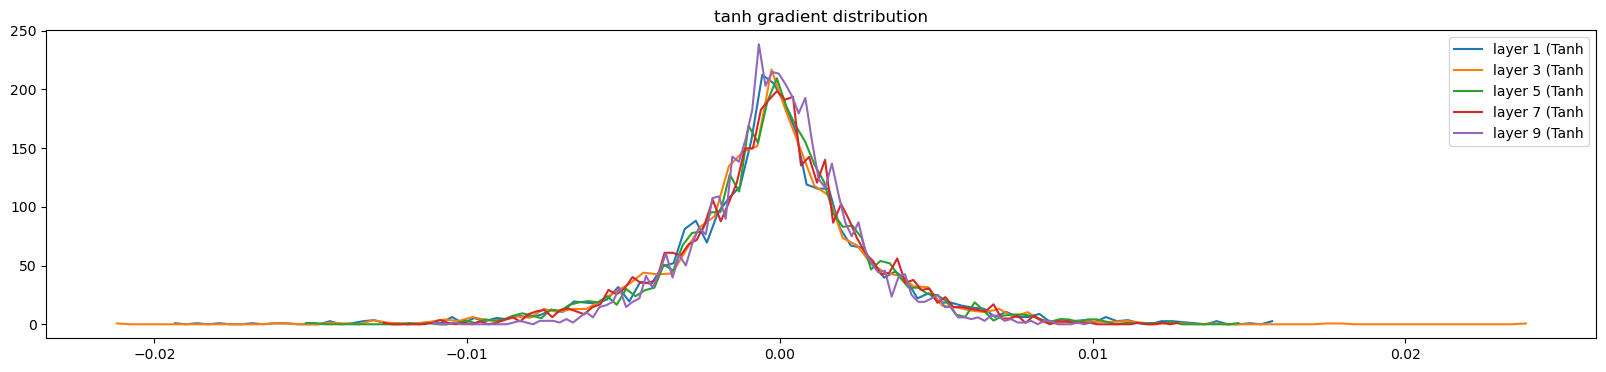

In [166]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # except output layer
    if isinstance(layer, Tanh):
        grad = layer.out.grad
        # due to the gain the gradients should be stable
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, grad.mean(), grad.std()))
        h_y, h_x = torch.histogram(grad, density=True)
        plt.plot(h_x[:-1].detach(), h_y.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    
plt.legend(legends);
plt.title('tanh gradient distribution')

Visualize weights gradients

grad to data ratio of the weights can be informative for undertsanding how much of a step up is occuring in the data, think of x+h, or x-h, in other words it can tell us how gradients have changed w.r.t to data

weight   (27, 10) | mean -0.000778 | std 1.119964e-02 | grad:data ratio 1.119103e-02
weight  (30, 100) | mean -0.000006 | std 9.959943e-03 | grad:data ratio 3.182398e-02
weight (100, 100) | mean +0.000035 | std 8.234476e-03 | grad:data ratio 4.900465e-02
weight (100, 100) | mean +0.000091 | std 7.020391e-03 | grad:data ratio 4.141925e-02
weight (100, 100) | mean -0.000049 | std 6.007064e-03 | grad:data ratio 3.559794e-02
weight (100, 100) | mean -0.000000 | std 4.967415e-03 | grad:data ratio 2.949064e-02
weight  (100, 27) | mean +0.000000 | std 2.013820e-02 | grad:data ratio 2.855440e-01


Text(0.5, 1.0, 'weights gradient distribution')

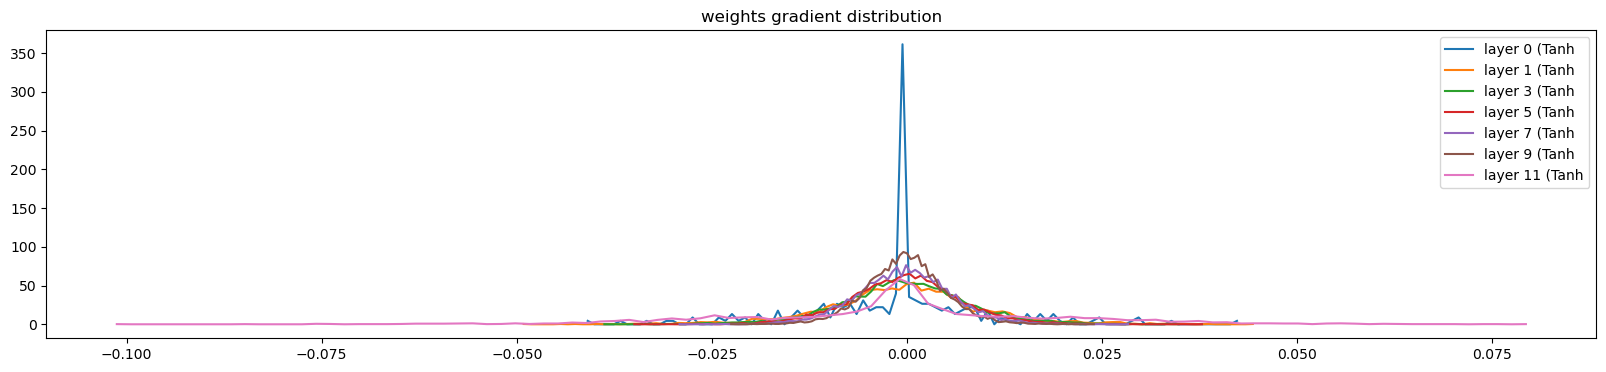

In [167]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(params):
    grad = p.grad
    if p.ndim == 2:
       
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' %(tuple(p.shape), grad.mean(), grad.std(), grad.std()/p.std()))
        h_y, h_x = torch.histogram(grad, density=True)
        plt.plot(h_x[:-1].detach(), h_y.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    
plt.legend(legends);
plt.title('weights gradient distribution')

Visualize Data Update to data Ratio
- try different learning rates, if the updates are too low(lower than 1e-3), we can try a higher one, this analysis can give us an idea about choosing a good learning rate
- are there layers which are learning too fast or too slow?

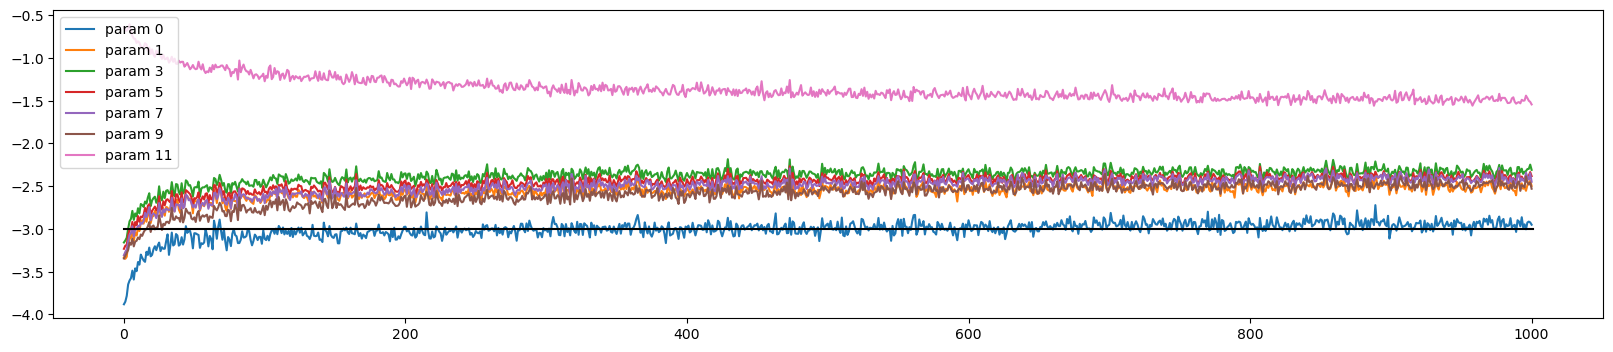

In [170]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(params):
    if p.ndim == 2:
        plt.plot([up_d_ratio[j][i] for j in range(len(up_d_ratio))])
        legends.append('param %d' %i)
# the approximate ideal value, which is 1e-3, the update shouldn't be greater than 1/1000 of the data
plt.plot([0, len(up_d_ratio)], [-3, -3], 'k')
plt.legend(legends);

Visualize Statistics - with Batch Normalization Layers

Notes
- Even with different values for gain, the activation, gradient, weights gradient distribution are much more robust with Batch Norm. We might have to change the learning rate if we change the gain to get good weight updates. 

- All the distributions are much more robust even when the initialization changed and fan_in**0.5 is removed

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'tanh activation distribution')

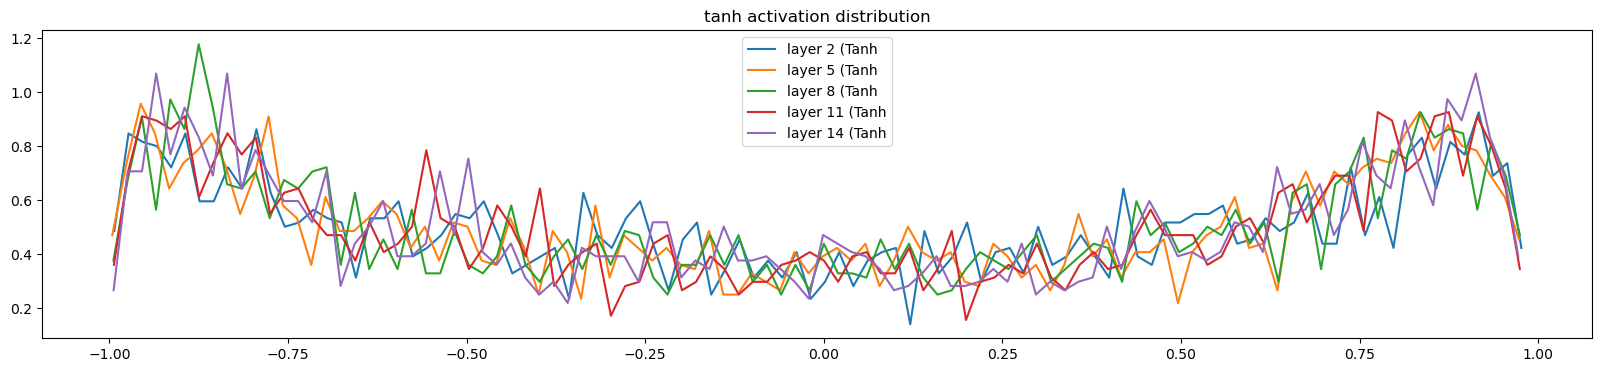

In [11]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # except the softmax layer
    if isinstance(layer, Tanh):
        out = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, out.mean(), out.std(), (out.abs() > 0.97).float().mean() * 100))
        h_y, h_x = torch.histogram(out, density=True)
        plt.plot(h_x[:-1].detach(), h_y.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    
plt.legend(legends);
plt.title('tanh activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.682946e-03
layer 5 (      Tanh): mean -0.000000, std 3.262604e-03
layer 8 (      Tanh): mean +0.000000, std 2.973726e-03
layer 11 (      Tanh): mean +0.000000, std 2.741104e-03
layer 14 (      Tanh): mean +0.000000, std 2.584291e-03


Text(0.5, 1.0, 'tanh gradient distribution')

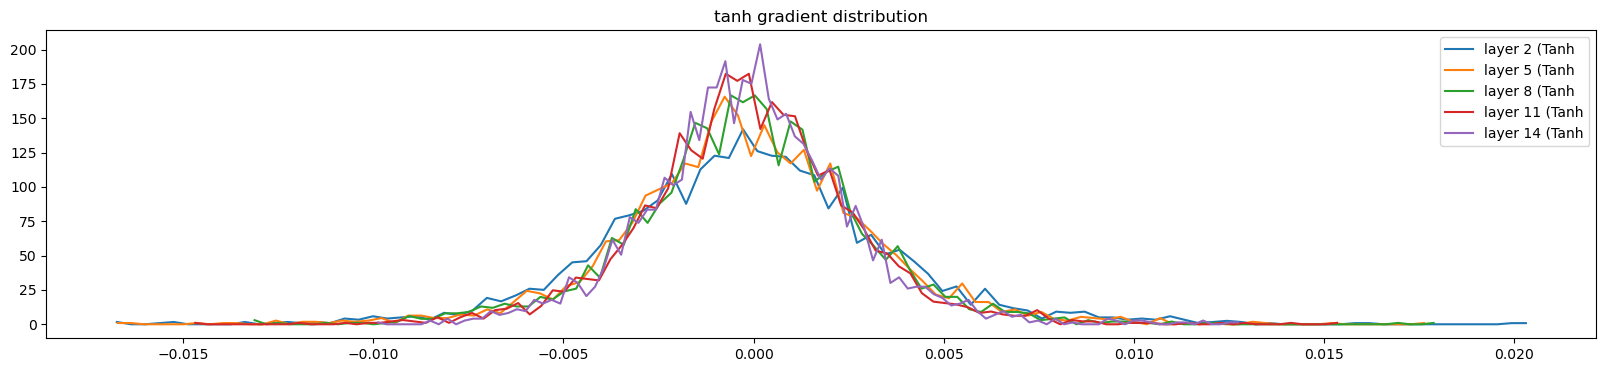

In [12]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # except output layer
    if isinstance(layer, Tanh):
        grad = layer.out.grad
        # due to the gain the gradients should be stable
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, grad.mean(), grad.std()))
        h_y, h_x = torch.histogram(grad, density=True)
        plt.plot(h_x[:-1].detach(), h_y.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    
plt.legend(legends);
plt.title('tanh gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.019881e-02 | grad:data ratio 1.018842e-02
weight  (30, 100) | mean +0.000092 | std 8.238411e-03 | grad:data ratio 2.635833e-02
weight (100, 100) | mean +0.000031 | std 7.318093e-03 | grad:data ratio 4.377133e-02
weight (100, 100) | mean -0.000019 | std 6.662015e-03 | grad:data ratio 3.949891e-02
weight (100, 100) | mean -0.000019 | std 5.821510e-03 | grad:data ratio 3.468157e-02
weight (100, 100) | mean +0.000053 | std 5.445287e-03 | grad:data ratio 3.243362e-02
weight  (100, 27) | mean -0.000165 | std 1.046843e-02 | grad:data ratio 6.281252e-02


Text(0.5, 1.0, 'weights gradient distribution')

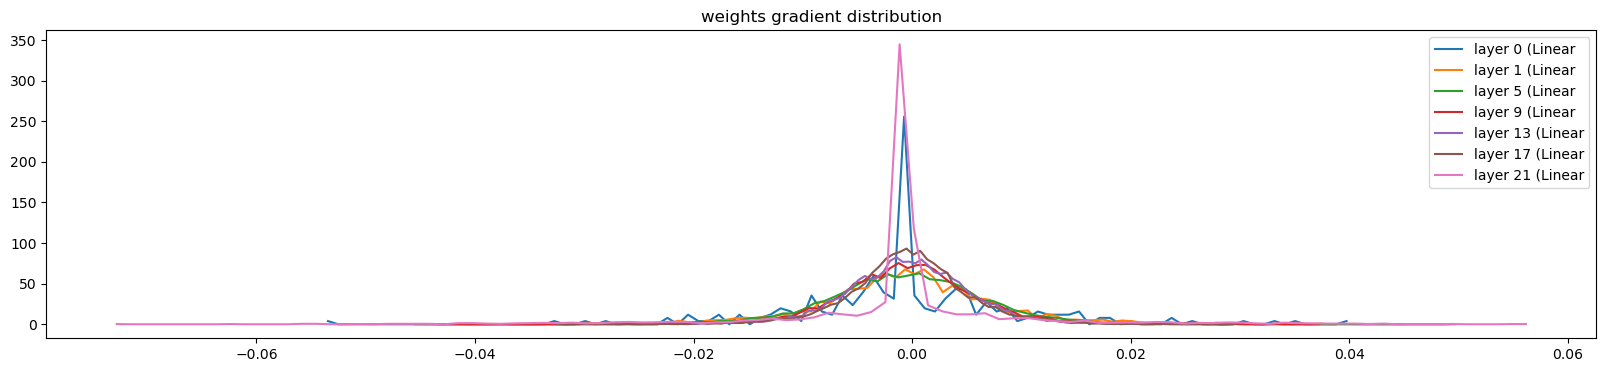

In [13]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(params):
    grad = p.grad
    if p.ndim == 2:
       
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' %(tuple(p.shape), grad.mean(), grad.std(), grad.std()/p.std()))
        h_y, h_x = torch.histogram(grad, density=True)
        plt.plot(h_x[:-1].detach(), h_y.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    
plt.legend(legends);
plt.title('weights gradient distribution')

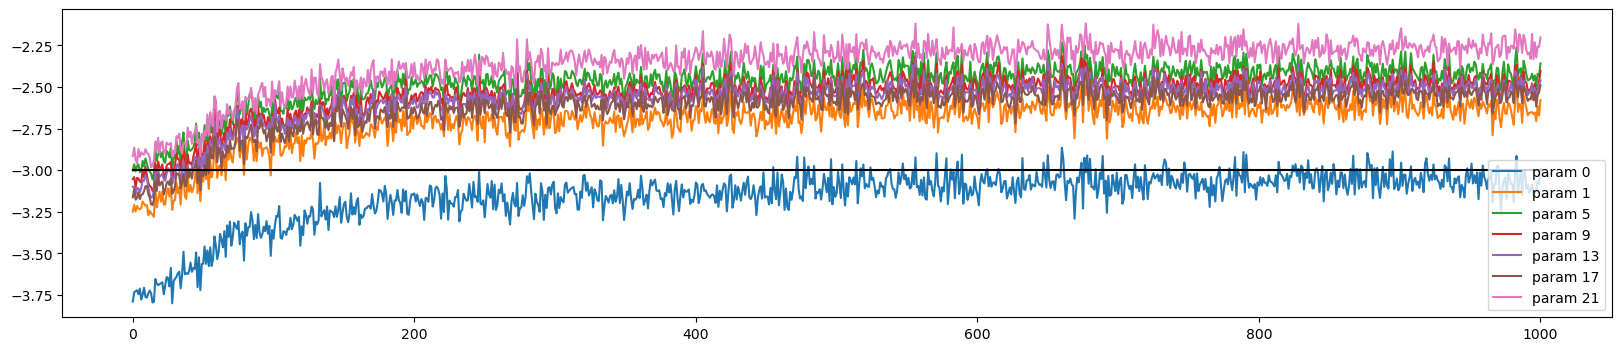

In [14]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(params):
    if p.ndim == 2:
        plt.plot([up_d_ratio[j][i] for j in range(len(up_d_ratio))])
        legends.append('param %d' %i)
# the approximate ideal value, which is 1e-3, the update shouldn't be greater than 1/1000 of the data
plt.plot([0, len(up_d_ratio)], [-3, -3], 'k')
plt.legend(legends);

### Manual Back Propagation

In [116]:
# boilerplate

words = open('names.txt', 'r').read().splitlines()
print(f'{len(words)}')
print(max(len(w) for w in words))
words[:8]

chars = list('abcdefghijklmnopqrstuvwxyz')
stoi_lookup = {c: i+1 for i, c in enumerate(chars)}
stoi_lookup['.'] = 0
itos_lookups = {i: char for char, i in stoi_lookup.items()}
vocab_size = len(itos_lookups)
print(itos_lookups)
print(vocab_size)

block_size = 3 # context length

def build_dataset(words):
    # input and output
    X, Y = [], []
    for word in words:
        # print('word: ', word)
        context = [0] * block_size
        seq = word + '.'    # don't forget to add the . add the end

        for char in seq:
            X.append(context)
            # index of the character to be predicted
            y_idx = stoi_lookup[char]
            Y.append(y_idx)
            # print(''.join(itos_lookups[c] for c in context), '--->', itos_lookups[y_i])
            # update the context for the next sequence
            context = context[1:] + [y_idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print("shapes: ", X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)

train_window_end = int(0.8*len(words))
val_window_end = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:train_window_end])  # used for optimizing the params of the model
X_val, Y_val = build_dataset(words[train_window_end:val_window_end])    #used for training the hyperparameters(hidden layer size, embedding size etc)
X_test, Y_test = build_dataset(words[val_window_end:])  # evaluating the performance of the model

32033
15
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
shapes:  torch.Size([182625, 3]) torch.Size([182625])
shapes:  torch.Size([22655, 3]) torch.Size([22655])
shapes:  torch.Size([22866, 3]) torch.Size([22866])


In [117]:
# utility function to compare the manual gradients to Pytorch Gradients

def compare_grads(s, man_grad, pt_grad):
    exact = torch.all(man_grad == pt_grad.grad).item()
    approx = torch.allclose(man_grad, pt_grad.grad)
    max_diff = (man_grad - pt_grad.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(exact):5s} | approx: {str(approx):5s} | maxdiff: {max_diff}')

set the biases to be small numbers instead of zeros as usual so that it doesnt mask an incorrect implementation/bug of a gradient

In [177]:
dim_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 64 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, dim_embd),             generator=g)

# LAYER 1
W1 = torch.randn((dim_embd* block_size, n_hidden),  generator=g) * (5/3)/(dim_embd* block_size) ** 0.5
b1 = torch.randn(n_hidden,                          generator=g) * 0.1 # this wont be useful because bath norm uses its own bias, keep it for checking the accuracy of gradient calculatioms

# LAYER 2
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.1 
b2 = torch.randn(vocab_size,                        generator=g) * 0.1

# BATCH NORMALIZATION PRAMETERS
# "scale and shift" batch normalization params
bn_gain = torch.ones((1, n_hidden)) * 0.1 + 1.0
bn_bias = torch.zeros((1, n_hidden)) * 0.1

params = [C, W1, W2, b2, bn_gain, bn_bias]
print(sum(p.nelement() for p in params))

# set the p.grad requires to true first so that we are able to get the grad for the params
for p in params:
    p.requires_grad = True

4073


In [178]:
batch_size = 32
n = batch_size 
# mini-batch construction
ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
Xb, Yb = X_train[ix], Y_train[ix]

forward pass for a single batch

In [182]:
# split the forward pass into chunks of smaller steps - we can backward one at a time

emb = C[Xb] # embed the chars into vectors
emb_cat = emb.view(emb.shape[0], -1) # vectors concatenation to make them 2D
# linear layer 1
h_prebn = emb_cat @ W1 + b1 # hidden layer pre-activation

# batch norm layer

# manual mean computation
bnmean_i = 1/n * h_prebn.sum(0, keepdim=True)
bn_diff = h_prebn - bnmean_i                # normalize the mean

bn_diff2 = bn_diff ** 2
bn_var = 1/(n - 1) * (bn_diff2).sum(0, keepdim=True)    # normalize the var

bn_var_inv = (bn_var + 1e-5) ** -0.5                     # epsilon to avoid divide by zero error
bn_raw = bn_diff * bn_var_inv
h_preact = bn_gain * bn_raw + bn_bias                   # scale and shift
# non linearity
h = torch.tanh(h_preact)
# linear layer 2
logits = h @ W2 + b2

# cross entropy loss
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # normalise the logits by subtracting max value(avoid numerical overflow)
# softmax evaluation
counts = norm_logits.exp() # since we have already noramlised the logits, the exp of them wont be too high 
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum ** -1
probs = counts * counts_sum_inv
log_probs = probs.log()            # log likelihood
loss = -log_probs[range(n), Yb].mean()  # average negative log liklehood for the single batch at index Yb

# PyTorch Backward pass
for p in params:
    p.grad = None

for t in [log_probs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logit_maxes, logits, h, h_preact, bn_raw, bn_var_inv, bn_var, bn_diff2, bn_diff, h_prebn, bnmean_i, emb_cat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3482, grad_fn=<NegBackward0>)

Task 1: Manual Backpropagation through the above chunks in the forward pass

In [234]:
# emb = C[Xb]
C.shape, emb.shape, Xb.shape

(torch.Size([27, 10]), torch.Size([32, 3, 10]), torch.Size([32, 3]))

In [233]:
# dlog_probs = torch.zeros(log_probs.shape)
dlog_probs = torch.zeros_like(log_probs)
dlog_probs[range(n), Yb] = -1.0/n
dlog_probs[range(n), Yb] = -1.0/n
dprobs = (1.0/probs) * dlog_probs

# shape of counts_sum_inv is (32, 1) and shape of counts is (32, 27), 
# because of brodcasting rules, that single value is replicated 27 times and then multiplication is applied, 
# hence we will sum the counts instead of just doing counts * dprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) 
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum ** -2) * dcounts_sum_inv
# we will add it to prev dcounts because counts is getting use twice, we get grads from two places
dcounts += torch.ones(dcounts_sum.shape) * dcounts_sum 
# or torch.ones_like(dcounts_sum) * dcounts_sum
dnorm_logits = norm_logits.exp() * dcounts
dlogits = 1 * dnorm_logits
dlogit_maxes = (-1 * dnorm_logits).sum(1, keepdim=True)
# dlogits += torch.ones_like(logits) * dlogit_maxes # this is correct
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes # this is the better way
dh = dlogits @ W2.T
dW2 = h.T @ dlogits 
db2 = (1.0 * dlogits).sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bn_raw * dhpreact).sum(0, keepdim=True)
dbnraw = bn_gain * dhpreact
dbnbias = (dhpreact).sum(0, keepdim=True)
dbndiff = bn_var_inv * dbnraw
dbnvarinv = (bn_diff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5 * (bn_var + 1e-5)** -1.5) * dbnvarinv
dbndiff2 = (1.0/(n-1)) * torch.ones_like(bn_diff2) * dbnvar
dbndiff += (2.0* bn_diff) * dbndiff2
dbnmeani = (-dbndiff).sum(0)
dhprebn = dbndiff.clone()
dhprebn += (1.0/n) * torch.ones_like(h_prebn) * dbnmeani
demb_cat = dhprebn @ W1.T
dW1 = emb_cat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = demb_cat.view(emb.shape)

dC = torch.zeros_like(C)
for i in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[i,j]
    dC[ix] += demb[i,j]

compare_grads('logprobs', dlog_probs, log_probs)
compare_grads('probs', dprobs, probs)
compare_grads('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

compare_grads('counts_sum', dcounts_sum, counts_sum)
compare_grads('counts', dcounts, counts) 
compare_grads('norm_logits', dnorm_logits, norm_logits)
compare_grads('logit_maxes', dlogit_maxes, logit_maxes)
compare_grads('logits', dlogits, logits)
compare_grads('h', dh, h)
compare_grads('W2', dW2, W2)
compare_grads('b2', db2, b2)
compare_grads('hpreact', dhpreact, h_preact)
compare_grads('bngain', dbngain, bn_gain)
compare_grads('bnbias', dbnbias, bn_bias)
compare_grads('bnraw', dbnraw, bn_raw)
compare_grads('bnvarinv', dbnvarinv, bn_var_inv)
compare_grads('bnvar', dbnvar, bn_var)
compare_grads('bndiff2', dbndiff2, bn_diff2)
compare_grads('bndiff', dbndiff, bn_diff)
compare_grads('bnmeani', dbnmeani, bnmean_i)
compare_grads('hprebn', dhprebn, h_prebn)
compare_grads('embcat', demb_cat, emb_cat)
compare_grads('W1', dW1, W1)
# compare_grads('b1', db1, b1)
compare_grads('emb', demb, emb)
compare_grads('C', dC, C)

logprobs        | exact: True  | approx: True  | maxdiff: 0.0
probs           | exact: True  | approx: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approx: True  | maxdiff: 0.0
counts_sum      | exact: True  | approx: True  | maxdiff: 0.0
counts          | exact: True  | approx: True  | maxdiff: 0.0
norm_logits     | exact: True  | approx: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approx: True  | maxdiff: 0.0
logits          | exact: True  | approx: True  | maxdiff: 0.0
h               | exact: True  | approx: True  | maxdiff: 0.0
W2              | exact: True  | approx: True  | maxdiff: 0.0
b2              | exact: True  | approx: True  | maxdiff: 0.0
hpreact         | exact: True  | approx: True  | maxdiff: 0.0
bngain          | exact: True  | approx: True  | maxdiff: 0.0
bnbias          | exact: True  | approx: True  | maxdiff: 0.0
bnraw           | exact: True  | approx: True  | maxdiff: 0.0
bnvarinv        | exact: True  | approx: True  | maxdiff: 0.0
bnvar   

Manual back-propagation for F.cross_entropy in one go without the chunks

In [237]:
loss_all_at_once = F.cross_entropy(logits, Yb)
print(loss_all_at_once.item(), 'diff: ', (loss_all_at_once - loss).item())

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

compare_grads('logits', dlogits, logits)

3.348198175430298 diff:  0.0
logits          | exact: False | approx: True  | maxdiff: 7.450580596923828e-09


Manual back-propagation for batchnorm in one go without the chunks

In [239]:
#TODO
h_preact_all_at_once = bn_gain * (h_prebn - h_prebn.mean(0, keepdim=True)) /torch.sqrt(h_prebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bn_bias
print('max diff:', (h_preact_all_at_once - h_preact).abs().max().item())


max diff: 9.5367431640625e-07


 __Reference: [Neural Networks: Zero to Hero by **Anderj Karpathy**](https://youtu.be/VMj-3S1tku0?si=nt0sYb9Rs2g4qApr)__